# **Fake news classifier**

In [113]:
# First we import the required libraries

import tensorflow as tf
import random
import numpy as np
import pandas as pd
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import io

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K 
K.clear_session()

# Check tensorflow version
if float(tf.__version__[0]) < 2.0:
  print('Updating tensorflow')
  !pip install tensorflow==2.0
else:
  print('Correct version of Tensorflow installed.')

Correct version of Tensorflow installed.


In [251]:
# Retrieve the data
df = pd.read_csv('rumor_detection_acl2017/twitter15/source_tweets.txt', sep=r'\t', engine='python')
df = df.fillna(' ')
df.head()
print(df.count())

label = pd.read_csv('rumor_detection_acl2017/twitter15/label.txt', sep=r':', engine='python')
label = label.fillna(' ')
label.head()
label.count()

df = df.merge(label)
df = df[df.label != 'unverified']
df = df[df.label != 'non-rumor']
df.label = pd.Categorical(df.label)
df['code'] = df.label.cat.codes

#df['label'] = df.label.astype('category').cat.codes
df.head()


ID      1490
text    1490
dtype: int64


,ID,text,label,code
4,551099691702956032,rip elly may clampett: so sad to learn #beverl...,true,1
7,514106273852174337,just in: missing afghan soldiers found trying ...,true,1
9,495366618818830336,#riphulkhogan my heart is ripping like your sh...,false,0
10,532206910796468224,a chick-fil-a manager allegedly banned this hi...,false,0
11,560187970389819392,islamic tribunal using sharia law in texas has...,false,0


In [255]:
# test data
df2 = pd.read_csv('rumor_detection_acl2017/twitter16/source_tweets.txt', sep=r'\t', engine='python')
df2 = df2.fillna(' ')
df2.head()
print(df2.count())

label2 = pd.read_csv('rumor_detection_acl2017/twitter16/label.txt', sep=r':', engine='python')
label2 = label2.fillna(' ')
label2.head()
label2.count()

df2 = df2.merge(label2)
df2 = df2[df2.label != 'unverified']
df2 = df2[df2.label != 'non-rumor']
df2.label = pd.Categorical(df2.label)
df2['code'] = df2.label.cat.codes

#df['label'] = df.label.astype('category').cat.codes
df2.head()

ID      818
text    818
dtype: int64


,ID,text,label,code
0,656955120626880512,correct predictions in back to the future ii URL,false,0
1,615689290706595840,.@whitehouse in rainbow colors for #scotusmarr...,true,1
2,613404935003217920,cops bought the alleged church shooter burger ...,false,0
5,614467824313106432,god put a rainbow over the white house 🌈 URL,true,1
9,622891631293935616,#wakeupamerica🇺🇸 who needs a #gun registry whe...,false,0


In [259]:
# Tokenize text

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
word_index = tokenizer.word_index
vocab_size=len(word_index)
print(vocab_size)

# Padding data

sequences = tokenizer.texts_to_sequences(df['text'])
padded = pad_sequences(sequences, maxlen=50, padding='post', truncating='post')
print(padded)

2729
[[ 135  236  108 ...    0    0    0]
 [  74    4   82 ...    0    0    0]
 [ 805  137  466 ...    0    0    0]
 ...
 [1251 1121 1247 ...    0    0    0]
 [ 172 2726   58 ...    0    0    0]
 [ 185 2729    1 ...    0    0    0]]


In [260]:
# Tokenize text test data

#tokenizer.fit_on_texts(df2['text'])
word_index2 = tokenizer.word_index
vocab_size2=len(word_index2)
print(vocab_size2)

# Padding data

sequences2 = tokenizer2.texts_to_sequences(df2['text'])
padded2 = pad_sequences(sequences2, maxlen=50, padding='post', truncating='post')
print(padded2)

2729
[[727 116   2 ...   0   0   0]
 [139   2  12 ...   0   0   0]
 [260 117   3 ...   0   0   0]
 ...
 [ 13  14  67 ...   0   0   0]
 [ 64 344  77 ...   0   0   0]
 [ 18  55 409 ...   0   0   0]]


In [244]:
from sklearn.model_selection import train_test_split
labels = df['code']
train_data, test_data, train_labels, test_labels = train_test_split(padded, labels, test_size=0.30)


In [261]:
train_data = padded
train_labels = df['code']
test_data = padded2
test_labels = df2['code']

In [262]:
# Import tensor representations for words

#!wget --no-check-certificate \
   # https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
   # -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('glove.twitter.27B.50d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;
print(len(coefs))

embeddings_matrix = np.zeros((vocab_size+1, 50));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

50


In [378]:
# Build the architecture of the model
     
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 50, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(32, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(10, return_sequences=True),
    tf.keras.layers.LSTM(10),
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Dense(256 ),
    tf.keras.layers.Dropout(0.3),  
    #tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [379]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

history = model.fit(train_data, train_labels, epochs=3, batch_size=100, validation_data=(test_data, test_labels))

print("Training Complete")

# saving the model
model_path = 'keras_fakenews7.h5'
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_45 (Embedding)     (None, None, 50)          136500    
_________________________________________________________________
dropout_129 (Dropout)        (None, None, 50)          0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, None, 32)          8032      
_________________________________________________________________
max_pooling1d_44 (MaxPooling (None, None, 32)          0         
_________________________________________________________________
lstm_89 (LSTM)               (None, None, 10)          1720      
_________________________________________________________________
lstm_90 (LSTM)               (None, 10)                840       
_________________________________________________________________
dropout_130 (Dropout)        (None, 10)              

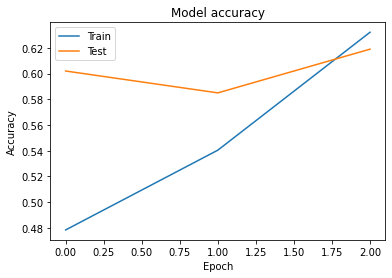

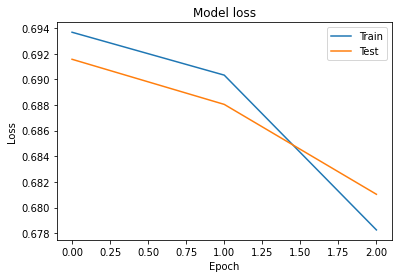

In [380]:
# Visualize the results:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [381]:
fakenews_model = tf.keras.models.load_model(model_path)
loss_and_metrics = fakenews_model.evaluate(test_data, test_labels, verbose=2)

print("Test Loss", loss_and_metrics[0])
print("Test Accuracy", loss_and_metrics[1])

13/13 - 0s - loss: 0.6810 - accuracy: 0.6189
Test Loss 0.6810334324836731
Test Accuracy 0.6189320683479309


<AxesSubplot:>

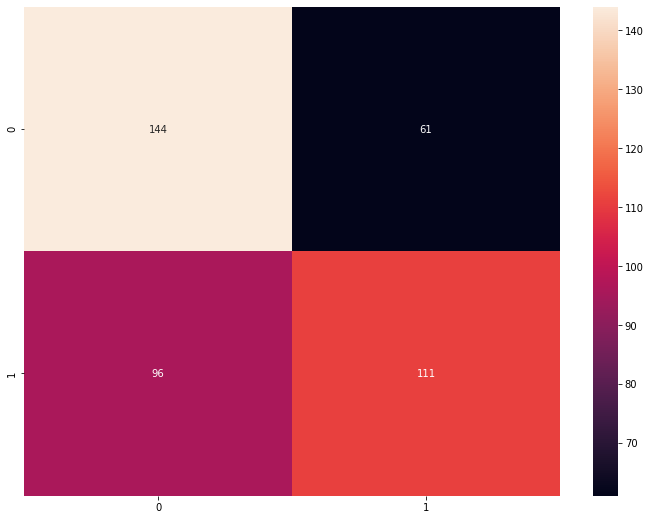

In [382]:
# load the model and create predictions on the test set
fakenews_model = tf.keras.models.load_model(model_path)
predicted_classes = fakenews_model.predict_classes(test_data)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true = test_labels, y_pred = predicted_classes)
import seaborn as sns
plt.figure(figsize=(12, 9))

sns.heatmap(cm, annot=True, fmt='d')
